In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [3]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Q1. Complete the compute entropy and compute gini functions.

# Decision Tree Class

In [4]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
    n_classes = np.unique(label_array)
    entropy = 0
    for label in n_classes:
        p = np.sum(label_array==label) / float(len(label_array))
        entropy += -p * np.log(p)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    n_classes = np.unique(label_array)
    gini = 0
    for label in n_classes:
        p = np.sum(label_array==label) / float(len(label_array))
        gini += p * (1 - p)
    return gini

# Q2. Complete the class Decision Tree, given in the skeleton code.

In [5]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # Your code goes here   
        if self.depth >= self.max_depth or len(y) <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            
        else:
            self.is_leaf = False
            min_loss = 9999999
            
            split_id, split_value = self.find_best_split(x, y, -1)
            
            self.left = Decision_Tree(self.split_loss_function, 
                                      self.leaf_value_estimator,
                                      self.depth + 1,
                                      self.min_sample,
                                      self.max_depth)

            self.right = Decision_Tree(self.split_loss_function, 
                                       self.leaf_value_estimator,
                                       self.depth + 1,
                                       self.min_sample,
                                       self.max_depth)

            x_split = x[split_id]
            y_split = y[split_id]
            
            left_x = x_split[ : split_value + 1]
            left_y = y_split[ : split_value + 1]
            right_x = x_split[split_value + 1 : ]
            right_y = y_split[split_value + 1 : ]
            
            self.left.fit(left_x, left_y)
            self.right.fit(right_x, right_y)
            
        return self
    


    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        best_loss = 999999
        
        for i in range(x_node.shape[1]):
            idx = np.argsort(x_node[:,i])
            x_sorted = x_node[idx]
            y_sorted = y_node[idx]
                
            for split_val in range(x_node.shape[0]-1):
                loss = (split_val + 1) * self.split_loss_function(y_sorted[ : split_val + 1]) \
                        + (x_node.shape[0] - split_val) * self.split_loss_function(y_sorted[split_val + 1 : ])

                if loss < best_loss:
                    best_loss = loss
                    self.split_id = i
                    self.split_value = (x_sorted[split_val, i] + x_sorted[split_val + 1, i]) / 2 
                    split_point = split_val
                    best_idx = idx
                    
        return best_idx, split_point

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        return split_id, split_value


    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [6]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [7]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Q3. Run the code provided that builds trees for the two-dimensional classification data. 

# Decision Tree Boundary

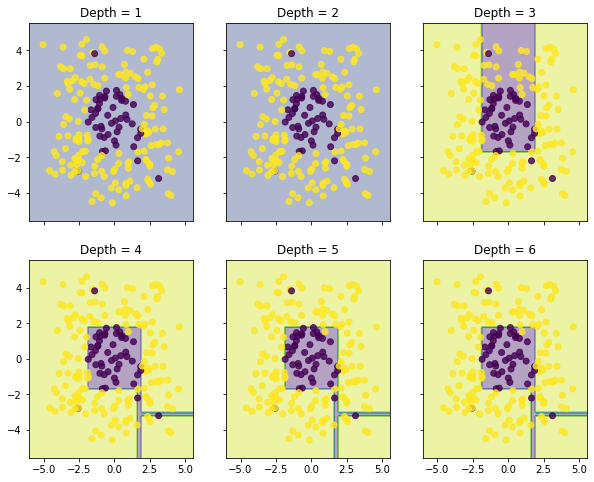

In [8]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [9]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

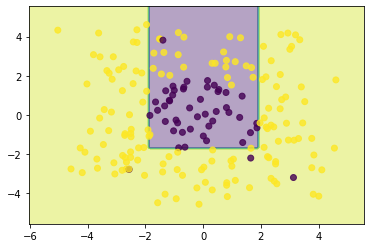

In [10]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

<Figure size 432x288 with 0 Axes>

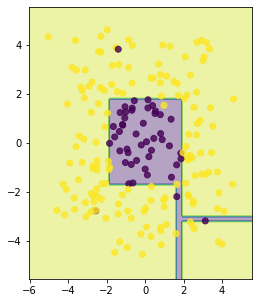

In [11]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(figsize=(4,5))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

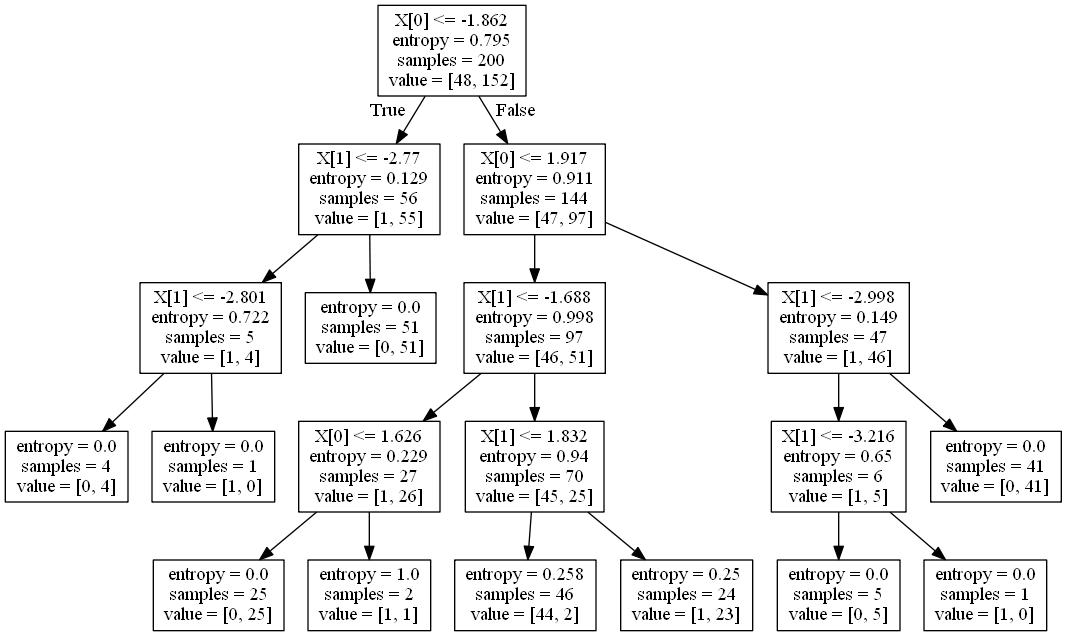

In [12]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Q4. Complete the function mean absolute deviation around median (MAE). 

# Decision Tree Regressor

In [13]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    median = np.median(y)
    mae = np.mean(np.abs(y - median))
    return mae

In [14]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

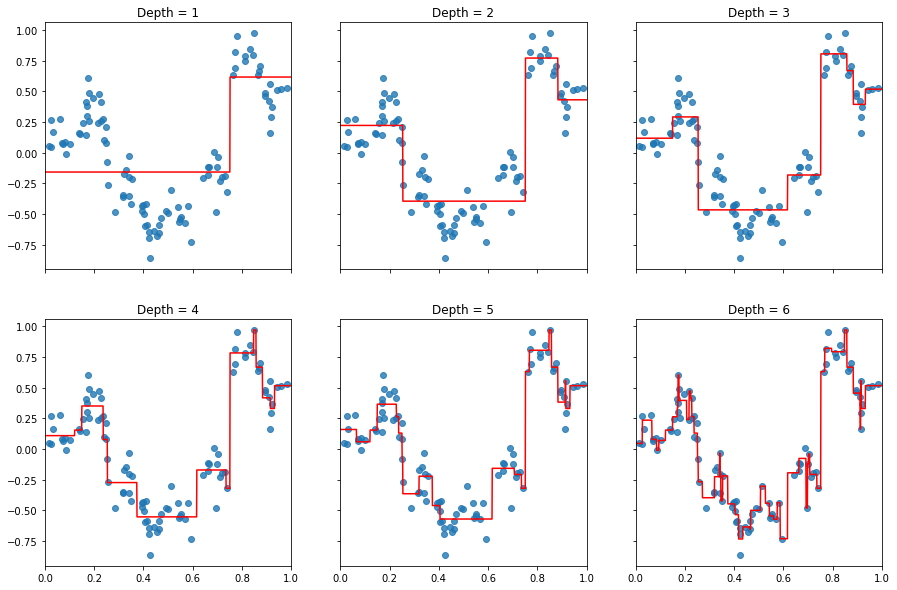

In [15]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

In [16]:
reg = DecisionTreeRegressor(criterion='mae', max_depth=10, min_samples_split=3)

# Q5. Complete the gradient boosting class. 
### As the base regression algorithm to compute the argmin, you should use sklearn’s regression tree. You should use the square loss for the tree splitting rule (criterion keyword argument) and use the default sklearn leaf prediction rule from the predict method 1 . We will also use a constant step size ν.

# Gradient Boosting Method

In [17]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [18]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # Your code goes here 
        for _ in range(self.n_estimator):            
            pseudo_residual = pseudo_residual_L2(train_target, self.predict(train_data))
            estimator = DecisionTreeRegressor(max_depth=self.max_depth,
                                                  min_samples_split=self.min_sample)
            estimator.fit(X = train_data, y = pseudo_residual)
            self.estimators.append(estimator)       
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here
        test_predict = np.zeros(len(test_data))
        for estimator in self.estimators:
            test_predict += self.learning_rate * estimator.predict(test_data)
        return test_predict


# 1-D GBM visualization - KRR data

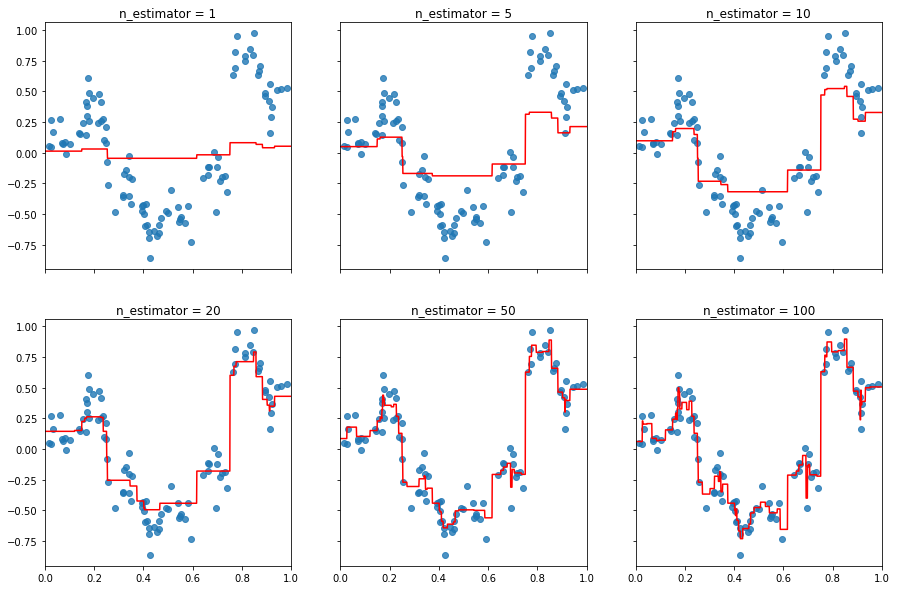

In [19]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Q9. Load the MNIST dataset using the helper preprocessing function in the skeleton code.
### Using the scikit learn implementation of GradientBoostingClassifier, with the logistic loss (loss=‘deviance’) and trees of maximum depth 3, fit the data with 2, 5, 10, 100 and 200 iterations (estimators). Plot the train and test accurary as a function of the number of estimators.

# Sklearn implementation for Classification of images

In [20]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [21]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

In [23]:
def calc_accuracy(estimators):
    train_acc = []
    test_acc = []
    for est in estimators:
        clf = GradientBoostingClassifier(loss='deviance', max_depth=3, n_estimators=est)
        clf.fit(X_train, y_train)
        train_acc.append(clf.score(X_train, y_train))
        test_acc.append(clf.score(X_test, y_test))
        print("n_estimators: ", est)
        print("train accuracy: ", clf.score(X_train, y_train))
        print("test accuracy: ", clf.score(X_test, y_test))
    return train_acc, test_acc

n_estimators:  2
train accuracy:  0.9954554635427186
test accuracy:  0.9952849528495284
n_estimators:  5
train accuracy:  0.9972732781256312
test accuracy:  0.995489954899549
n_estimators:  10
train accuracy:  0.9972732781256312
test accuracy:  0.9952849528495284
n_estimators:  100
train accuracy:  1.0
test accuracy:  0.998359983599836
n_estimators:  200
train accuracy:  1.0
test accuracy:  0.9985649856498565


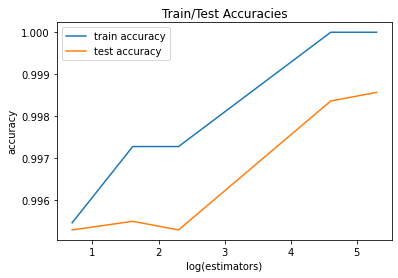

In [24]:
estimators = [2,5,10,100,200]
train_acc, test_acc = calc_accuracy(estimators)

plt.plot(np.log(estimators), train_acc, label = "train accuracy")
plt.plot(np.log(estimators), test_acc, label = "test accuracy")
plt.title("Train/Test Accuracies")
plt.xlabel("log(estimators)")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Q10. Another type of ensembling method we discussed in class are random forests. Explain in your own words the construction principle of random forests.

From a set of data, we get B bootstrap samples and construct a tree for each boostrap sample. Each tree is constructed using the following procedure. 

1. Randomly select m subset of features from the total number of features.
2. Select the best split point among m variables.
3. Split the node into child nodes based on the optimal split point.

Once all trees are constructed, aggregate using mean for regressor and majority vote for classification.

Randomly selecting variables and training on different samples of the data to construct each tree reduces variance and helps with overfitting. 

# Q11. Using the scikit learn implementation of RandomForestClassifier3, with the entropy loss (criterion=‘entropy’) and trees of maximum depth 3, fit the preprocessed binary MNIST dataset with 2, 5, 10, 50, 100 and 200 estimators.

In [25]:
def calc_acc_random_forest(estimators):
    train_acc = []
    test_acc = []
    for est in estimators:
        rfc = RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=est)
        rfc.fit(X_train, y_train)
        train_acc.append(rfc.score(X_train, y_train))
        test_acc.append(rfc.score(X_test, y_test))
        print("n_estimators: ", est)
        print("train accuracy: ", rfc.score(X_train, y_train))
        print("test accuracy: ", rfc.score(X_test, y_test))
    return train_acc, test_acc

n_estimators:  2
train accuracy:  0.9864673803272066
test accuracy:  0.9862648626486265
n_estimators:  5
train accuracy:  0.9972732781256312
test accuracy:  0.996309963099631
n_estimators:  10
train accuracy:  0.9971722884265805
test accuracy:  0.997539975399754
n_estimators:  100
train accuracy:  0.9980811957180368
test accuracy:  0.9981549815498155
n_estimators:  200
train accuracy:  0.9975762472227833
test accuracy:  0.9985649856498565


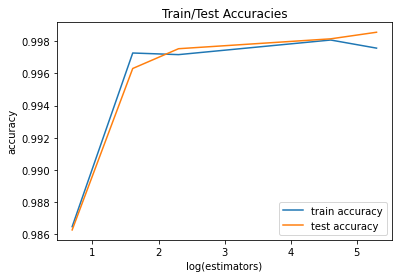

In [26]:
estimators = [2,5,10,100,200]
train_acc, test_acc = calc_acc_random_forest(estimators)

plt.plot(np.log(estimators), train_acc, label = "train accuracy")
plt.plot(np.log(estimators), test_acc, label = "test accuracy")
plt.title("Train/Test Accuracies")
plt.xlabel("log(estimators)")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Q12. What general remark can you make on overfitting for Random Forests and Gradient Boosted Trees? 
## Which method achieves the best train accuracy overall? Is this result expected? Can you think of a practical disadvantage of the best performing method? How do the algorithms compare in term of test accuracy?

Both Random Forests and Gradient Boosted Trees result in high training and test accuracies. In the case of Gradient Boosted Trees, training and testa accuracies are over 99% for all numbers of estimators that were used and both accuracies increases with increasing number of iterations (estimators). In addition, train accuracy is higher than test accuracy, which shows Gradient Boosted Trees' resistance to overfitting. In the case of Random Forests, as the number of iterations increases, test accuracy continues to increase even when the training accuracy starts to decrease. 

Gradient Boosted Trees achieves the best train accuracy as it eventually reaches a 100% training accuracy. This result is expected because during training, Gradient Boosted Trees focus on fixing the errors made in the previous stage so with increasing number of iterations, it will eventually end up fixing all mistakes. One practical disadvantage of this method of Gradient Boosted Trees, although it is the best performing method, is that it will continue to fixing all mistakes that it will also focus on any outliers that exist in the training data, which could potentially lead to overfitting.

In terms of test accuraccy, Random Forests achieve better test accuracy than Gradient Boosted Trees. 

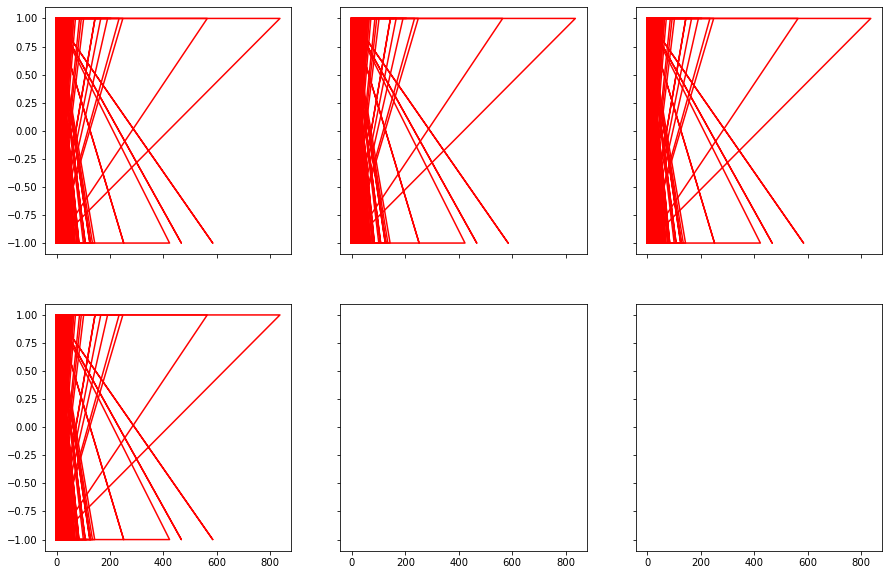

In [27]:
plot_size = 0.001
#x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [2, 5, 10, 100 and 200], 
                       ['n_estimator = {}'.format(n) for n in [2, 5, 10, 100 and 200]]):
    
    gbm_1d = GradientBoostingClassifier(loss='deviance',n_estimators=i,
                               max_depth=3, learning_rate=0.1)  
    

    gbm_1d.fit(X_train, y_train)
    
    y_range_predict = gbm_1d.predict(X_test)

    axarr2[idx[0], idx[1]].plot(X_test, y_range_predict, color='r')
#     axarr2[idx[0], idx[1]].scatter(X_train, y_train, alpha=0.8)
#     axarr2[idx[0], idx[1]].set_title(tt)
#     axarr2[idx[0], idx[1]].set_xlim(0, 1)